In [1]:
!git pull https://github.com/Francesco215/Quantum-diffusion.git

From https://github.com/Francesco215/Quantum-diffusion
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from src import *
from tqdm.auto import tqdm


if torch.backends.mps.is_available():
    device = torch.device("mps")

NOTE: Redirects are currently not supported in Windows or MacOs.


In [3]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [5]:
timesteps=1000

times=torch.ones(len(images))*timesteps*0.1
#alpha=cosine_schedule(times,timesteps)
k=0.5
alpha=torch.ones(len(images))-.2

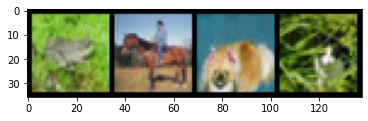

tensor(nan)


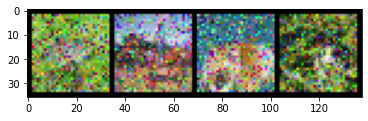

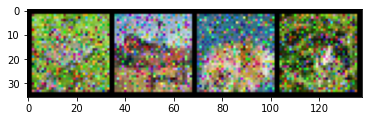

frog  horse dog   cat  


In [6]:
imshow(torchvision.utils.make_grid(images))

images=decimal_to_binary(images)
noisy_images_digital=bernoulli_noise(images,alpha,k)
noisy_images_digital=binary_to_decimal(noisy_images_digital)

images=binary_to_qubits(images)
noisy_images=gaussian_noise(images,alpha,k)
print(cross_entropy(noisy_images,images))
noisy_images=qubit_to_decimal(noisy_images)

images=qubit_to_decimal(images)

imshow(torchvision.utils.make_grid(noisy_images))
imshow(torchvision.utils.make_grid(noisy_images_digital))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
n_bits = 8

In [8]:
model = Unet(
    dim = 32,
    channels = 3,
    dim_mults = (1, 2, 4, 8),
    bits = n_bits,
).to(device)

diffusion = BitDiffusion(model, image_size = 32).to(device)


In [9]:
def cross_entropy(probability,target):
    target=target+0.5
    return -torch.mean(target*torch.log(probability + 1e-8) + (1-target)*torch.log(1-probability + 1e-8))


def gaussian_noise(img:torch.Tensor, alpha:torch.Tensor, k:float=1):
    """Takes a batch of images and adds to each one of them a gaussian.
        The gaussian noise can be applied only if the img is in the qubit representation
    Args:
        img (torch.Tensor): images to add noise to
        alpha (torch.Tensor): the sqrt(1-alpha) is the variance of the gaussian noise
        k (float): it is a parameter that changes the way the gaussian noise id added. Defaults to 1. 

    Returns:
        torch.Tensor: The noised images
    """
    assert alpha.shape[0]==img.shape[0], f'alpha must have the same size as the batch size of img, alpha has {alpha.shape[0]} and img has {img.shape[0]}'
    assert img.dtype == torch.float, f'img must be in the qubit representation, img has dtype {img.dtype}'

    mu, sigma = torch.sqrt(alpha), torch.sqrt(1-alpha)*k

    

    noise = torch.randn_like(img).to(img.device)

    while not torch.any(torch.isnan(noise)):
        noise = torch.randn_like(img).to(img.device)


    #       x*sqrt(alpha)                           +           noise*sqrt(1-alpha)
    return torch.einsum("b, b... -> b...", mu, img) + torch.einsum("b, b... -> b...", sigma, noise)


In [10]:
# Train the model

optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-3)

for epoch in range(10):
    for i, (images, _) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        
        images = images.to(device)
        images = decimal_to_qubits(images)
        
        alpha = torch.rand(len(images),device=device)
        noised_images = gaussian_noise(images, alpha, k)
        
        if torch.any(torch.isnan(noised_images)):
            raise Exception ("Noised images contain NaNs")

        predicitions = diffusion.forward(noised_images, alpha, self_conditioning=False)
        probabilities = torch.sin(k*predicitions*np.pi)**2

        loss = cross_entropy(probabilities, images)
        loss.backward()
        optimizer.step()

        if i % 20 == 0:
            print(f'[{epoch + 1}, {i + 1}] loss: {loss.item():.3f}')

  0%|          | 0/12500 [00:00<?, ?it/s]/Users/francesco/Github/Quantum-diffusion/src/utils.py:31: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  x = (x & mask) != 0
  0%|          | 1/12500 [00:17<62:25:02, 17.98s/it]

[1, 1] loss: nan


  0%|          | 6/12500 [00:39<22:50:16,  6.58s/it]


KeyboardInterrupt: 

In [ ]:
torch.any(torch.isnan(noised_images))

tensor(True, device='mps:0')

In [ ]:
#!pip install pytorch-fid
from pytorch_fid import fid_score
fid_score()
!python -m pytorch_fid "path/to/dataset1" "path/to/dataset2"